In [17]:
import hazm 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from io import StringIO
from string import punctuation
from sklearn.svm import LinearSVC
from IPython.display import display
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [18]:
# بارگزاری اطلاعات
df = pd.read_csv('AllComments.csv')

# حذف اطلاعات تکراری
df = df[pd.notnull(df['Label'])]
df = df[pd.notnull(df['comment'])]
df = df.drop_duplicates()

In [3]:
# 'category_id' ایجاد یک ستون به نام 
df2 = df.copy()
df2['category_id'] = df2['Label'].factorize()[0]
category_id_df = df2[['Label', 'category_id']].sort_values('category_id')

# ایجاد یک دیکشنری
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)

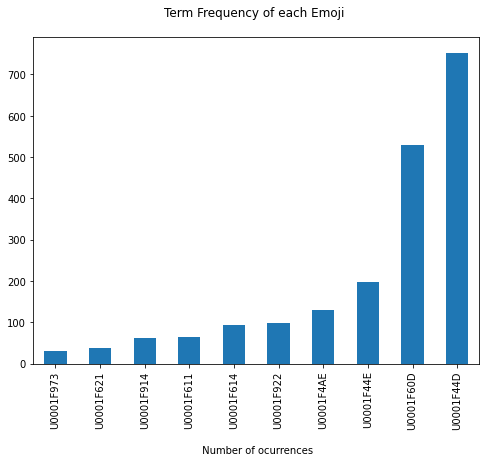

In [19]:
# ایجاد یک نمود فراوانی تکرار ایموجی‌ها
fig = plt.figure(figsize=(8,6))
df2.groupby('Label').comment.count().sort_values().plot.bar(
    ylim=0, title= 'Term Frequency of each Emoji \n')
plt.xlabel('\n Number of ocurrences', fontsize = 10);
plt.show()

In [20]:
# پالایش کامنت‌ها
normalizer =  hazm.Normalizer()
tokenizer = hazm.SentenceTokenizer()
tokens = hazm.word_tokenize 
S_Words = list(hazm.stopwords_list())


In [21]:
#بازنمایی متن
tfidf = TfidfVectorizer(lowercase=False, 
                        preprocessor=normalizer.normalize, 
                        tokenizer=tokens,
                        ngram_range=(1, 2),
                        stop_words=S_Words)
comments = df2.comment
features = tfidf.fit_transform(comments).toarray()
labels = df2.category_id

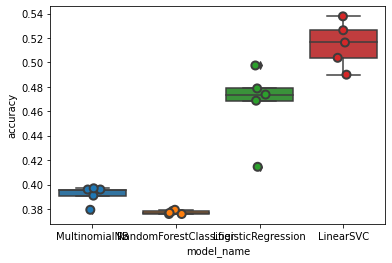

In [7]:
# مقایسه همه مدل‌ها
models = [
    MultinomialNB(),
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),
    LogisticRegression(random_state=0),
    LinearSVC(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))     
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']

In [25]:
# یافتن 3 کلمه پرتکرار برای هر ایموجی 
N = 3
for Label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Label))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'U0001F44D':
  . Top unigrams:
       . خوبه
       . راضیم
       . خوبیه
  . Top bigrams:
       . حتما بخرید
       . خرید داره
       . ازش راضیم
# 'U0001F44E':
  . Top unigrams:
       . اصلا
       . نمی‌ارزه
       . تأثیرش
  . Top bigrams:
       . خریدن نداره
       . قیمتش نمی‌ارزه
       . ماندگاری ضعیفی
# 'U0001F4AE':
  . Top unigrams:
       . قدرت
       . دارو
       . عااالیه
  . Top bigrams:
       . واقعا راضی
       . ابعاد استاندارد
       . کیفیت ابعاد
# 'U0001F60D':
  . Top unigrams:
       . عالیه
       . هستم
       . العاده
  . Top bigrams:
       . راضی هستم
       . واقعا عالیه
       . قیمتش عالیه
# 'U0001F611':
  . Top unigrams:
       . گرونه
       . گرون
       . وجه
  . Top bigrams:
       . خوبه گرون
       . . وجه
       . گرون تره
# 'U0001F614':
  . Top unigrams:
       . نمیکنم
       . افتضاح
       . پشیمونم
  . Top bigrams:
       . پیشنهاد نمیکنم
       . اصلا پیشنهاد
       . پیشنهاد نمی‌کنم
# 'U0001F621':
  . Top unigrams:
       . شکننده
 

In [66]:
# MultinominalNB مدل پیش بینی 
X = df2['comment'] 
y = df2['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
tfidf_transformer = TfidfTransformer()
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10, n_classes=11, random_state=0)
estimator = GaussianNB()
y_pred = cross_val_predict(estimator, X, y, cv=10)
print("\n \t\t **************************************")
print("\t\t  MultinominalNB Classification Report  ")
print("\t\t ************************************** \n\n")
print(metrics.classification_report(y, y_pred))
# One example Pridiction ( Without Learning Model !!) .....

exampleComment = " ارزش خرید دارد "
print("Comment: " , exampleComment)
print("Related emoji: ", clf.predict(count_vect.transform([exampleComment])))


 		 **************************************
		  MultinominalNB Classification Report  
		 ************************************** 


              precision    recall  f1-score   support

           0       0.27      0.28      0.28       181
           1       0.39      0.59      0.47       181
           2       0.26      0.33      0.29       184
           3       0.31      0.19      0.23       185
           4       0.36      0.30      0.32       183
           5       0.25      0.25      0.25       179
           6       0.42      0.50      0.45       182
           7       0.29      0.21      0.24       184
           8       0.32      0.46      0.38       181
           9       0.29      0.30      0.30       178
          10       0.18      0.07      0.10       182

    accuracy                           0.31      2000
   macro avg       0.30      0.31      0.30      2000
weighted avg       0.30      0.31      0.30      2000

Comment:   ارزش خرید دارد 
Related emoji:  ['U0001F44D'

In [61]:
# RandomForest مدل پیش بینی 
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.8, random_state = 21)
                                                                                          
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
Model.fit(X_train, y_train)

y_pred = Model.predict(X_test)

print("\n \t\t ************************************")
print("\t\t  RandomForest Classification Report  ")
print("\t\t ************************************ \n\n")
print(metrics.classification_report(y_test, y_pred, target_names= df2['Label'].unique()))



 		 ************************************
		  RandomForest Classification Report  
		 ************************************ 


              precision    recall  f1-score   support

   U0001F44E       0.00      0.00      0.00       150
   U0001F4AE       0.00      0.00      0.00       106
   U0001F44D       0.38      1.00      0.56       614
   U0001F922       0.00      0.00      0.00        75
   U0001F611       0.00      0.00      0.00        52
   U0001F60D       0.00      0.00      0.00       416
   U0001F973       0.00      0.00      0.00        27
   U0001F914       0.00      0.00      0.00        51
   U0001F621       0.00      0.00      0.00        32
   U0001F614       0.00      0.00      0.00        72

    accuracy                           0.38      1595
   macro avg       0.04      0.10      0.06      1595
weighted avg       0.15      0.38      0.21      1595



In [68]:
# LinearSVC مدل پیش بینی
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df2.index, test_size=0.8, random_state=1)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n \t\t *********************************")
print("\t\t  LinearSVC Classification Report  ")
print("\t\t ********************************* \n\n")
print(metrics.classification_report(y_test, y_pred, target_names=df['Label'].unique()))

newComment = """عطر بدبوی بود اصلا نخرید"""

X_input = df2['comment']
y_input = df2['Label'] 
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, 
                                                    test_size=0.8,
                                                    random_state = 0)

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

print("Comment: " , newComment)
print((model.predict(fitted_vectorizer.transform([newComment])))

SyntaxError: unexpected EOF while parsing (<ipython-input-68-db6abaa20e5f>, line 26)